# Demonstration using the US adult income data

The US adult income dataset contains data on 48842 individuals including their income (classed into 2 categories: over 50k or under 50k), age, education, etc. The primary goal is to determine whether an individual makes over 50k a year or not.

Source: https://archive.ics.uci.edu/ml/datasets/adult

**This Jupyter notebook will put to the test the feedfoward neural network (multilayer perceptron) that was written from scratch without dependence on any ML libraries.**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import model_selection, preprocessing
import sys

In [2]:
import my_multilayer_peceptron_network_oop as nn

In [3]:
data=pd.read_csv("../datasets/adult-income-data/adult.csv")

In [4]:
display(data.head())
display(data.describe())

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


# Preprocessing of data

Drop missing values by converting all forms of missing values (e.g. "?") to np.NaN, and then drop the NaN.

In [5]:
data.replace(to_replace="?", value=np.NaN, inplace=True)

In [6]:
data.dropna(inplace=True)

Find categorical columns by using the fact that columns with strings are stored as object dtype. Then convert the categorical columns to numerically ordinal and then to onehot. 

For instance, if each entry in a column can only take on one of the following strings "aaa", "bb", and "cc", which means it's a categorical column, then the column can be coverted to only take on the integers 1, 2, and 3 as a numerical representation for "aaa", "bb", and "cc".

In [7]:
categoricalColsMask=(data.dtypes==object)
categoricalColNames=data.dtypes.loc[categoricalColsMask].index

In [8]:
# Convert categorical columns to numerically ordinal.

cat_ordinal_map=dict()
for colName in categoricalColNames:
    cat_ordinal=[]
    for i,clss in enumerate(data.loc[:,colName].unique()):
        mask=data.loc[:,colName]==clss
        data.loc[mask,colName]=i
        cat_ordinal.append((clss, i))
    cat_ordinal_map[colName]=cat_ordinal

Scale the data using minmax normalization.

In [9]:
# Code lifted from another of my projects:  https://github.com/princyok/my_ml_support

def minmaxNormalize(df, customMinMax=None):
    """
    Scales each variable in the data such that the minimum and maximum values 
    are rescaled to 0 and 1, and values that are inbetween are scaled proportionally.
    """
    df=df.copy()
    if customMinMax==None:
        df=(df-df.min())/(df.max()-df.min())
    else:
        for colName in customMinMax:
            min_, max_ = customMinMax.get(colName)
            df.loc[:,colName]=(df.loc[:,colName]-min_)/(max_ - min_)
    return df

In [10]:
nonCategColsMask=~data.columns.isin(categoricalColNames)
data.loc[:,nonCategColsMask]=minmaxNormalize(data.loc[:,nonCategColsMask])

In [11]:
# Code lifted from another of my projects:  https://github.com/princyok/my_ml_support

# Note: the same can be achieved using sklearn.preprocessing.OneHotEncoder with sklearn.compose.make_column_transformer.

def oneHotEncode(df, colNames, drop=False):
    """
    Applies onehot encoding to specified columns.

    Parameters:

        df: the DataFrame.

        colNames: the colunm (str or array-like) or columns (array-like) to encode.

    Returns:
        a DataFrame with the onehot-encoded data (original columns are excluded).
    """
    if isinstance(colNames,str): colNames=[colNames]
    colNames=np.array(colNames) # covert to np array in case it already isn't.
    df=df.copy()

    # identify all the binary categorical columns (col with 2 or less unique values).
    colNames_ordinal_encode=[]
    locs=[]
    for i,colName in enumerate(colNames):
        cats=df.loc[:,colName].unique()
        if len(cats)<=2:
            colNames_ordinal_encode.append(colName)
            locs.append(i)   

    # apply ordinal encoding to binary categorical columns.
    # Same result as onehote encoding, without generatin new columns.
    if len(colNames_ordinal_encode)>0:

        colNames=np.delete(colNames,locs) # remove the already encoded binary categorical columns.

        encoder=preprocessing.OrdinalEncoder(dtype=np.int32)

        # convert to np array and ensure its 2D.
        temp=df.loc[:,colNames_ordinal_encode].to_numpy().reshape(-1,len(colNames_ordinal_encode))
        df.loc[:,colNames_ordinal_encode]=encoder.fit_transform(temp)

        # ensure dtypes of the encoded columns are int.
        for c in colNames_ordinal_encode:
            # for some reason, doing it all at once for all columns doesn't do anything.
            df.loc[:,c]=df.loc[:,c].astype("int32") 

    # apply onehot-encoding to the rest.
    encoder=preprocessing.OneHotEncoder(dtype=np.int32)
    encodedArr=encoder.fit_transform(df.loc[:,colNames].to_numpy()) # returns a scipy csr_matrix object.
    encodedArr=encodedArr.toarray() # convert to np array.

    newColNames=encoder.get_feature_names(input_features=colNames) # returns an np array of lists, each with one elem (the column name).
    newColNames=newColNames.ravel() # unpack the np array to just an array of column names.

    # combine the newly onehot-encoded array to the df.
    df=df.join(pd.DataFrame(encodedArr, columns=newColNames, index=df.index))

    # omit the old columns.
    colNames_to_retain=list(colNames_ordinal_encode)+list(newColNames)
    df=df.loc[:,colNames_to_retain]

    return df

In [12]:
# convert categorical columns (nominal) to onehot columns.

data = oneHotEncode(data,colNames=categoricalColNames,drop=True)

C:\Users\princ\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
data.head()

,sex,income,workclass_0.0,workclass_1.0,workclass_2.0,workclass_3.0,workclass_4.0,workclass_5.0,workclass_6.0,education_0.0,...,native.country_31.0,native.country_32.0,native.country_33.0,native.country_34.0,native.country_35.0,native.country_36.0,native.country_37.0,native.country_38.0,native.country_39.0,native.country_40.0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
mask_income_0 = (data["income"]==0)

print("number of records for classes 0", len(data.loc[mask_income_0, "income"].index))
print("number of records for classes 1", len(data.loc[~mask_income_0, "income"].index))

number of records for classes 0 22654
number of records for classes 1 7508


We observe that the distribution of the classes is very unbalanced. We resample the training set to have equal number of records across the classes. This enables the network to not give preference to one class over the other due to class imbalance.

In [15]:
# Code lifted from another of my projects:  https://github.com/princyok/my_ml_support


def resampleToBalance(df, classColName):

    df=df.copy()

    # get number of instances in the smallest class (by instances).
    numberOfInstances=df.groupby(by=classColName).size().min()

    classes=df.loc[:,classColName].unique()
    result=pd.DataFrame(columns=df.columns)
    origDtypes=df.dtypes

    for cls in classes:
        selection=df[df.loc[:,classColName]==cls].iloc[0:numberOfInstances].copy()

        # reset index and drop it into the df as a new col.
        selection.reset_index(inplace=True)

        result=result.append(selection, ignore_index=True,sort=False)
    # ensure that the dropped index col is integer.    
    result.loc[:,"index"]=result.loc[:,"index"].astype('int32')

    # set the dropped index col as the new index.
    result.set_index(keys="index", drop=True, inplace=True)

    # set the dtypes back to those in the original df.
    for colName,dtype in origDtypes.to_dict().items():
        result.loc[:,colName]=result.loc[:,colName].astype(dtype)

    return result.sort_index(axis=0) # restore original order, in case if originally sequential.

In [16]:
data=resampleToBalance(df=data.sample(n=len(data.index)), classColName="income")

Split the dataset into training and test sets, as well as x and y.

In [17]:
featuresMask=(data.columns!="income")
targetMask=(data.columns=="income")


In [18]:
data_train, data_test=model_selection.train_test_split(data,train_size=0.9, random_state=5)

In [19]:
x_train=data_train.loc[:,featuresMask].to_numpy().T
y_train=data_train.loc[:,targetMask].to_numpy().T.reshape(1,-1)

x_test=data_test.loc[:,featuresMask].to_numpy().T
y_test=data_test.loc[:,targetMask].to_numpy().T.reshape(1,-1)

# Learning

Biuld the layers for the network

In [20]:
l1=nn.Layer("relu", 10)
l2=nn.Layer("relu", 20)
l3=nn.Layer("relu", 40)
l4=nn.Layer("relu", 80)
l5=nn.Layer("logistic",1)

Instantiate the network and add the layers to it.

In [21]:
layers=[l1, l2, l3, l4, l5]
network=nn.Network(X=x_train,Y=y_train)
network.add_layers(layers)

Initialize the parameters of the network.

In [22]:
network.initialize_parameters(factor=0.01)

Instantiate an archiver for the network. The archiver will cache components of the network as specified.

In [23]:
archiver=nn.TrainingArchiver(10) # cache all components every 10 iterations.
archiver.set_archiving_verbosities(accuracy=True) # we want information about accuracy to be printed in each caching event.

network.add_training_archiver(archiver)

Train the network

In [24]:
num_iterations=500
learning_rate=9e-1
batch_size=2048

network.train(num_iterations=num_iterations, batch_size=batch_size, learning_rate=learning_rate)

Training Begins...
training accuracy, iter. 10:  0.72412
validation accuracy, iter. 10:  0.74249
training accuracy, iter. 20:  0.74707
validation accuracy, iter. 20:  0.75936
training accuracy, iter. 30:  0.72168
validation accuracy, iter. 30:  0.74338
training accuracy, iter. 40:  0.77295
validation accuracy, iter. 40:  0.76217
training accuracy, iter. 50:  0.77344
validation accuracy, iter. 50:  0.76698
training accuracy, iter. 60:  0.75684
validation accuracy, iter. 60:  0.76854
training accuracy, iter. 70:  0.77051
validation accuracy, iter. 70:  0.76691
training accuracy, iter. 80:  0.73047
validation accuracy, iter. 80:  0.76358
training accuracy, iter. 90:  0.76562
validation accuracy, iter. 90:  0.77668
training accuracy, iter. 100:  0.75732
validation accuracy, iter. 100:  0.76846
training accuracy, iter. 110:  0.79736
validation accuracy, iter. 110:  0.78282
training accuracy, iter. 120:  0.75928
validation accuracy, iter. 120:  0.77705
training accuracy, iter. 130:  0.79395


Evaluate the network using the test set.

In [29]:
print(network.evaluate(X=x_test,Y=y_test, metric="accuracy"))

0.788948069241012


plotting the training and validation costs.

C:\Users\princ\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


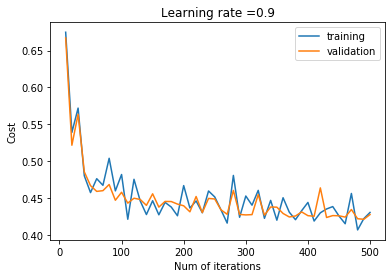

In [26]:
x_plot=list(archiver.all_training_costs.keys())

fig, ax = pyplot.subplots(1, 1)

ax.plot(x_plot,list(archiver.all_training_costs.values()), label="training")
ax.plot(x_plot,list(archiver.all_validation_costs.values()), label="validation")


ax.set_ylabel('Cost')
ax.set_xlabel('Num of iterations')
ax.set_title("Learning rate =" + str(learning_rate))
ax.legend()
fig.show()

Plot the training and validation accuracies

C:\Users\princ\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


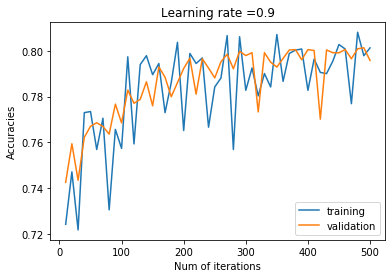

In [27]:

x_plot=list(archiver.all_training_accuracies.keys())

fig, ax = pyplot.subplots(1, 1)

ax.plot(x_plot,list(archiver.all_training_accuracies.values()), label="training")
ax.plot(x_plot,list(archiver.all_validation_accuracies.values()), label= "validation")

ax.set_ylabel('Accuracies')
ax.set_xlabel('Num of iterations')
ax.set_title("Learning rate =" + str(learning_rate))
ax.legend()
fig.show()